# 1. Import libraries

In [1]:
# Data processing  
# -----------------------------------------------------------------------  
import pandas as pd  
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------  
pd.options.display.max_colwidth = None
 
# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore")

# Custom functions
# -----------------------------------------------------------------------
from src.eda_support import * # Revisar qué funciones necesito de aquí
from src.circuit_clustering_model.extract import extract_races_and_results_dataframes

In [2]:
import fastf1

# Config less verbosity
fastf1.set_log_level('ERROR')

# 2. Data loading

In [7]:
df_races = pd.read_csv('../data/output/races.csv', index_col=0)

df_races = df_races.loc[:, ['season', 'round', 'circuitId']]

In [45]:
df_races

,season,round,circuitId
0,2021,1,bahrain
1,2021,2,imola
2,2021,3,portimao
3,2021,4,catalunya
4,2021,5,monaco
5,2021,6,baku
6,2021,7,ricard
7,2021,8,red_bull_ring
8,2021,9,red_bull_ring
9,2021,10,silverstone


In [19]:
try:
    df = pd.read_csv('../data/output/circuits.csv', index_col=0)

except FileNotFoundError:
    print("Data not found: Extracting data...")
    df = extract_races_and_results_dataframes(df_races)
    df.to_csv('../data/output/circuits.csv')


In [46]:
df

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,gear_changes
bahrain,SOFT,88.997,311.0,5391.107500,15,174.591753,218.342318,73.134771,18.059299,55.0
imola,SOFT,74.411,290.0,4899.232778,19,214.538960,237.668831,81.048701,13.961039,40.0
portimao,MEDIUM,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,40.0
catalunya,SOFT,76.741,313.0,4665.113611,16,177.564519,219.068966,75.727273,16.300940,40.0
monaco,SOFT,70.346,279.0,3276.551111,19,146.219753,168.225256,59.266212,26.279863,48.0
baku,SOFT,101.218,314.0,5941.759444,20,161.305898,211.635714,72.121429,18.095238,60.0
ricard,SOFT,89.990,328.0,5758.101389,15,180.285584,230.943850,71.048128,16.844920,44.0
red_bull_ring,SOFT,63.720,315.0,4287.503889,10,210.427041,242.996226,78.260377,13.962264,37.0
silverstone,SOFT,86.023,322.0,5823.959444,18,224.376002,244.170868,79.507003,11.764706,35.0
hungaroring,SOFT,75.419,303.0,4338.096389,14,174.059255,207.203822,71.649682,16.560510,44.0


# 3. Data description

El conjunto de datos a analizar consiste en una tabla cuyas entradas son circuitos del campeonato del mundo de F1. Los circuitos se corresponden con las entradas que podemos encontrar en el dataframe `df_races`, cuyo detalle de extracción se puede encontrar en [poner fichero].

A partir de estos datos, la función `extract_races_and_results_dataframes()` se encarga de recuperar la información necesaria para caracterizar un circuito a partir de la vuelta más rápida de la clasificación (pole position).

Se ha utilizado la pole position porque normalmente es la vuelta más rápida del fin de semana y es menos sensible a estrategias de carrera como selección de neumáticos o cargas de combustible.

Para clusterizar adecuadamente los circuitos se han recopilado diferentes características clave de los mismos a partir de la telemetría de la vuelta. Los datos clave obtenidos (columnas del dataframe) son:

* `compound`: Compuesto con el que se ha llevado a cabo la vuelta de la pole position. 

* `laptime`: Tiempo total de la vuelta, en segundos.

* `max_speed`: Velocidad máxima alcanzada en la trampa de velocidad, en km/h.

* `distance`: Longitud total del circuito.

* `n_corners`: Número total de curvas del trazado.

* `avg_corner_speed`: Velocidad promedio de paso por curva, en km/h.

* `avg_speed`: Velocidad media de la vuelta, en km/h.

* `throttle_perc`: Porcentaje de acelerador a lo largo de la vuelta.

* `brake_perc`: Porcentaje de freno a lo largo de la vuelta.

* `gear_changes`: Número total de cambios de marcha a lo largo de la vuelta.

Nota: la columna `compound` no la utilizaremos en el clustering sino que la utilizamos para filtrar vueltas en las que la sesión haya sido en mojado, lo que puede sesgar las condiciones del circuito. 

Inicialmente no eliminaremos los duplicados, y conservaremos entradas del mismo circuito a lo largo de varias temporadas. Esto permitirá que podamos tener al menos una entrada en condiciones de seco para cada circuito, lo que es más representativo de las características del mismo.

In [27]:
df.head()

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,gear_changes
bahrain,SOFT,88.997,311.0,5391.107500,15,174.591753,218.342318,73.134771,18.059299,55.0
imola,SOFT,74.411,290.0,4899.232778,19,214.538960,237.668831,81.048701,13.961039,40.0
portimao,MEDIUM,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,40.0
catalunya,SOFT,76.741,313.0,4665.113611,16,177.564519,219.068966,75.727273,16.300940,40.0
monaco,SOFT,70.346,279.0,3276.551111,19,146.219753,168.225256,59.266212,26.279863,48.0


Podemos ver de qué temporadas tenemos circuitos

In [23]:
df_races['season'].unique()

array([2021])

Y cuántos circuitos diferentes tenemos en total

In [25]:
df_races['circuitId'].nunique()

21

Nota: deberíamos considerar eliminar las curvas que sean a fondo y/o agrupar las curvas o rectas por velocidad

Esto son next steps. Hacer si da tiempo

Más next steps: Añadir un campo que sea si es urbano o no y ver si hay diferencias significativas o cómo afecta a los clusters.

# 4. Exploratory data analysis

En este caso, todas las columnas son numéricas.

In [28]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
laptime,21.0,82.92,12.68,63.72,75.42,80.83,89.00,116.02
max_speed,21.0,314.48,15.42,279.00,307.00,315.00,322.00,346.00
distance,21.0,5123.10,853.36,3276.55,4338.10,5253.13,5758.10,6940.38
n_corners,21.0,16.57,3.60,10.00,15.00,16.00,19.00,27.00
avg_corner_speed,21.0,188.59,24.20,144.17,174.59,188.74,197.86,238.82
avg_speed,21.0,222.98,20.28,168.23,211.64,221.56,237.67,260.64
throttle_perc,21.0,74.09,6.17,59.27,71.05,74.30,78.26,83.15
brake_perc,21.0,15.89,3.48,10.44,13.96,16.28,17.49,26.28
gear_changes,21.0,43.00,8.65,32.00,36.00,40.00,47.00,64.00


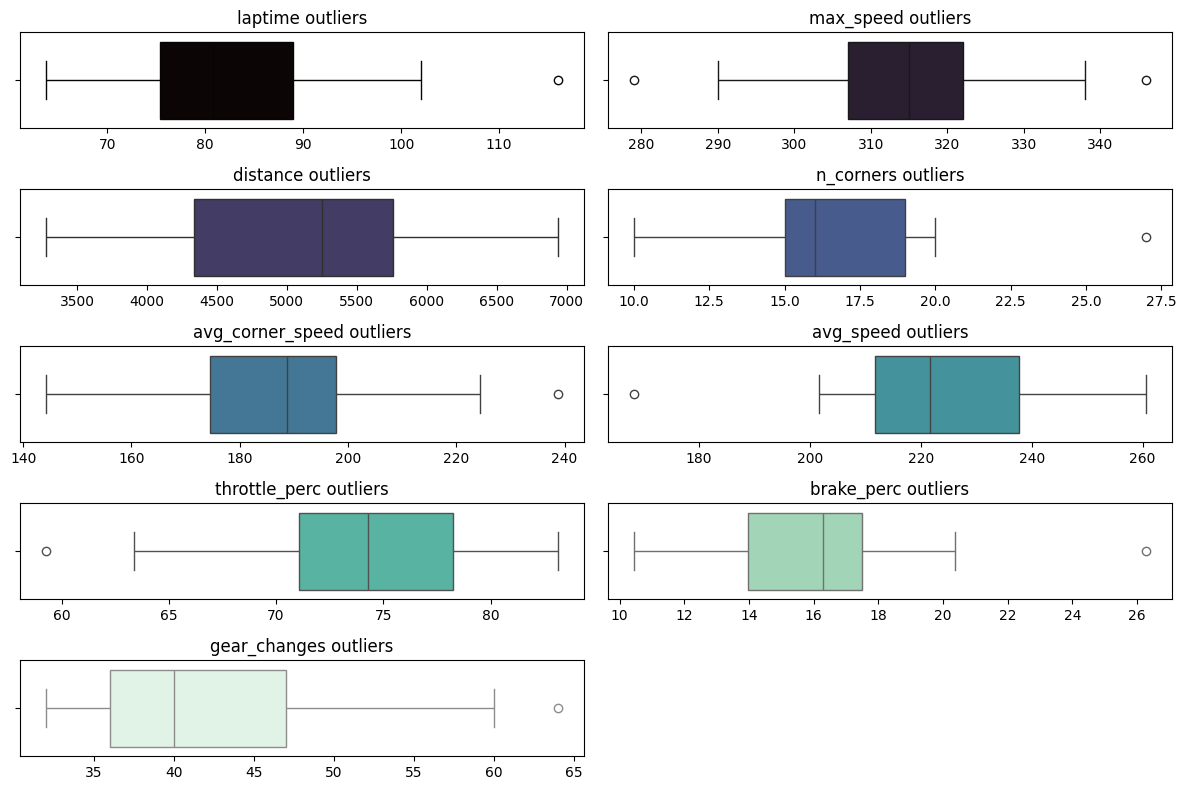

In [29]:
plot_outliers(df, size = (12, 8))

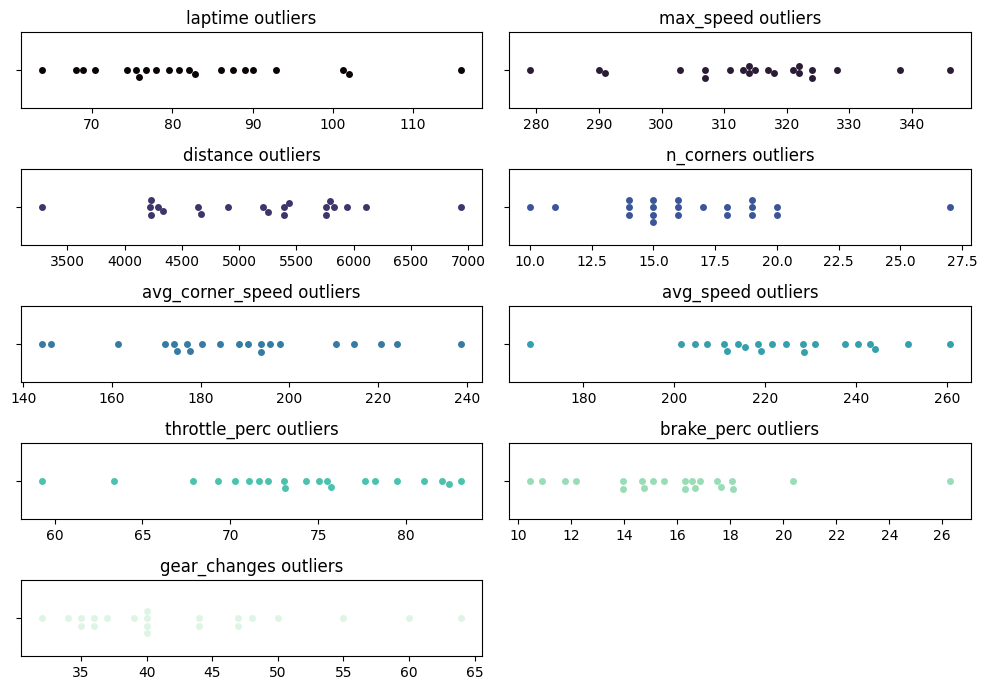

In [43]:
df_num = df.select_dtypes(include = np.number)
cols_num = df_num.columns

n_plots = len(cols_num)
num_rows = math.ceil(n_plots/2)

cmap = plt.cm.get_cmap('mako', n_plots)
color_list = [cmap(i) for i in range(cmap.N)]

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10,7))
axes = axes.flat

for i, col in enumerate(cols_num):

    sns.swarmplot(x = col, 
                data = df_num,
                ax = axes[i],
                color=color_list[i]) 
    
    axes[i].set_title(f'{col} outliers')
    axes[i].set_xlabel('')

# Remove last plot, if empty
if n_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

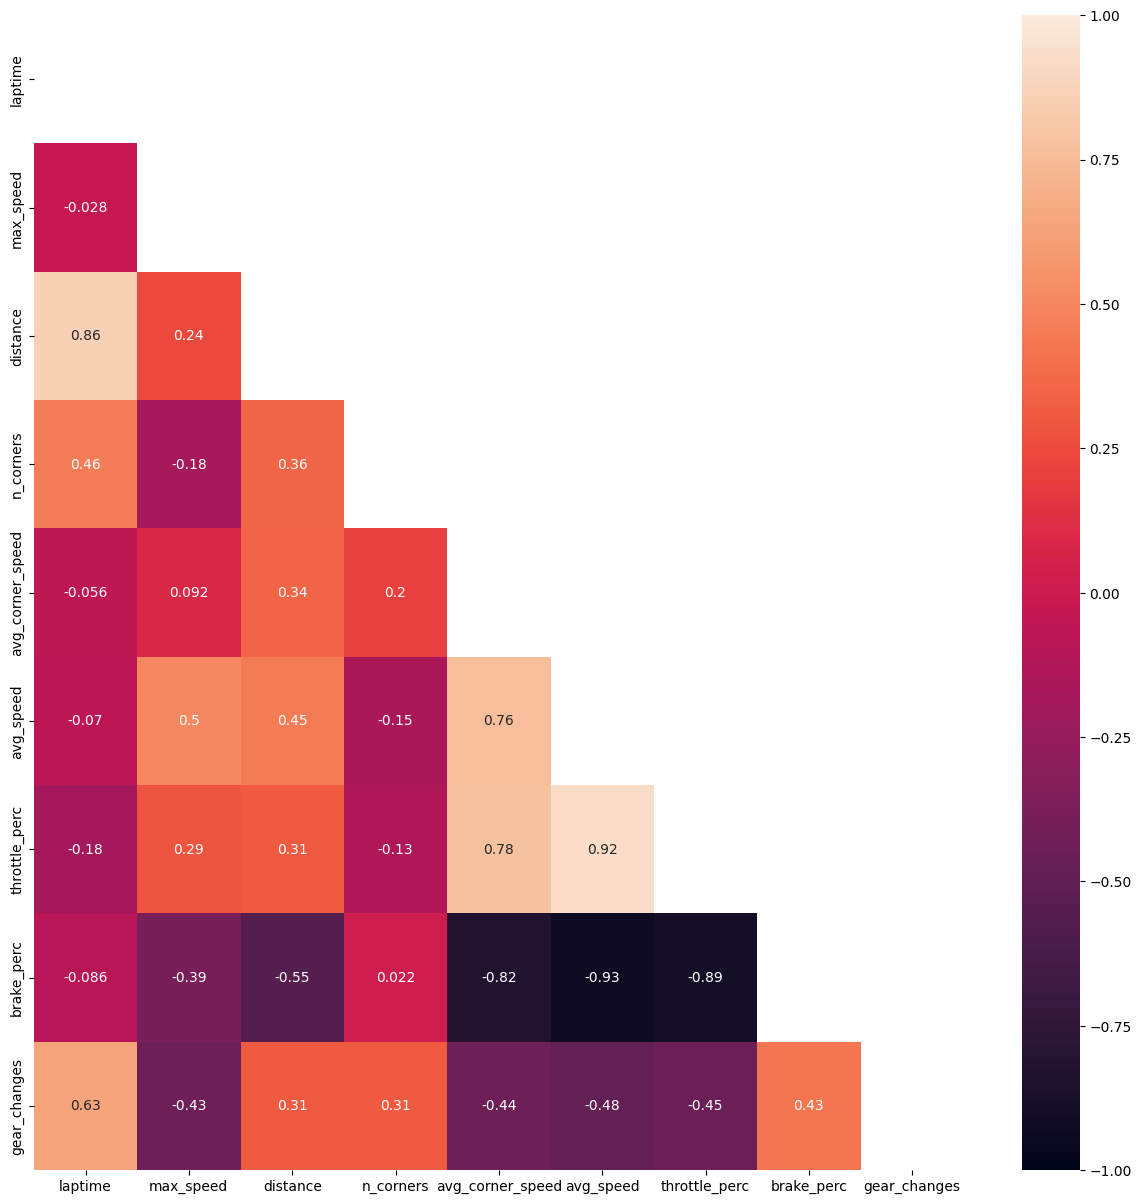

In [44]:
plot_correlation_matrix(df, size = (15, 15))

---

Inspeccionamos Mexico

In [3]:
from src.circuit_clustering_model.extract import get_circuit_info

# Mexico
dc, lap, car_data, corners = get_circuit_info(2021, 18)

In [43]:
dc, lap, car_data, corners = get_circuit_info(2021, 16)

In [44]:
straights = corners['Distance'].diff()

straights.iloc[0] = dc['distance'] - corners['Distance'].iloc[-1] + corners['Distance'].iloc[0]

straights = straights.iloc[:-1]

In [45]:
straights

0     702.016571
1     338.166772
2     388.796029
3     124.416942
4     161.396510
5      91.925388
6     523.864498
7     615.583902
8     752.255593
9      79.834303
10    522.731773
11    760.943921
12    110.789959
Name: Distance, dtype: float64

In [46]:
car_data

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2021-10-09 12:56:21.443,10812,260,7,100,False,12,car,0 days 00:00:00.172000,0 days 01:08:27.400000,12.422222
1,2021-10-09 12:56:21.723,10825,267,7,100,False,12,car,0 days 00:00:00.452000,0 days 01:08:27.680000,33.188889
2,2021-10-09 12:56:21.963,11085,271,7,100,False,12,car,0 days 00:00:00.692000,0 days 01:08:27.920000,51.255556
3,2021-10-09 12:56:22.203,11181,275,7,100,False,12,car,0 days 00:00:00.932000,0 days 01:08:28.160000,69.588889
4,2021-10-09 12:56:22.443,11279,277,7,100,False,12,car,0 days 00:00:01.172000,0 days 01:08:28.400000,88.055556
...,...,...,...,...,...,...,...,...,...,...,...
340,2021-10-09 12:57:43.083,10792,232,5,100,False,12,car,0 days 00:01:21.812000,0 days 01:09:49.040000,5187.733333
341,2021-10-09 12:57:43.323,11330,237,6,100,False,12,car,0 days 00:01:22.052000,0 days 01:09:49.280000,5203.533333
342,2021-10-09 12:57:43.563,11599,245,6,100,False,12,car,0 days 00:01:22.292000,0 days 01:09:49.520000,5219.866667
343,2021-10-09 12:57:43.802,11891,249,6,100,False,12,car,0 days 00:01:22.531000,0 days 01:09:49.759000,5236.397500


Next steps

* Eliminar curvas que sean a fondo

* Incluir rectas

* Contar número de curvas en función de la velocidad

* Número de frenadas